# Plan:
### We will initially look at our greater data set of all surveyed women from the Chicago Women's Health study that includes the screening  of both women indentified as abused and not abused.  We will use this data to determine the status and probability of any given woman being in a domestically abusive situation.

### This first pipeline to identify the abuse status of a woman will be referred to as "Phase 1" and be done on our first dataframe set that we will refer to as "Dataframe A" or "dfa." 

### "Phase 2" will utilize the subset of women that were identified as abused in the study and compound extra features that were gleaned in a follow-up survey of these identified women.  These features will be narrowed and modeled to identify risk of being reassaulted.  This work can be found in the "Phase 2" Notebook and will investigate appropriately on a compounded dataframe of our original features in addition to the new features from the follow-up survey.

### Hypothesis: From domain knowledge of this field, we predict that there will likely be significant identifiers of abuse that can be fed into a machine-learned model.

# ENVIRONMENT

In [1]:
# basic environment and custom scripts
import os
import acquire
import prepare
import explore
import time

# numpy and pandas for dataframe building and manipulation
import pandas as pd
import numpy as np


# matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns

# import preprocessing for scaling and splitting
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# xgboost for feature selection
import xgboost as xgb

# sklearn machine learning
# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import SGDClassifier
# NB:
from sklearn.naive_bayes import GaussianNB
# classification reports
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# SVM
from sklearn.svm import SVC
# Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Dimensionality
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# cross-validation, grid-search
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


# visualization for tree model:
import graphviz
from io import StringIO
from IPython.display import Image 
import pydotplus

#  balanced bagging classifier
from imblearn.ensemble import BalancedBaggingClassifier

# to explode the DataFrames and avoid truncation
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

# ACQUISITION

In [2]:
# utilize acquire script to get primary dataframe for analysis
dfa, dfb = acquire.get_data()

In [3]:
# run info for initial peek at dataframe
dfa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 705 entries, 0 to 704
Data columns (total 44 columns):
CASEID      705 non-null int64
ABUSED      705 non-null int64
SCRSTATR    705 non-null int64
LENGTHC1    705 non-null int64
C1SITUAT    705 non-null int64
PABUSE      705 non-null int64
D3RCHILT    705 non-null int64
E13PRGNT    705 non-null int64
N7PREGNT    705 non-null int64
TOTSUPRT    705 non-null int64
G1NUMBER    705 non-null int64
H1JEALUS    705 non-null int64
H2LIMIT     705 non-null int64
H3KNOWNG    705 non-null int64
J1HIT       705 non-null int64
J2THROWN    705 non-null int64
J3PUSH      705 non-null int64
J4SLAP      705 non-null int64
J5KICK      705 non-null int64
J6OBJECT    705 non-null int64
J7BEAT      705 non-null int64
J8CHOKE     705 non-null int64
J9KNIFE     705 non-null int64
J10GUN      705 non-null int64
J11SEX      705 non-null int64
POWER       705 non-null int64
HARASS      705 non-null int64
B1AGE       705 non-null int64
AGEDISP     705 non-null in

## _'dfb' : this is the dataframe with the AW (Abused Woman) cases_

In [4]:
# placeholder cell: perhaps going to utilize these in a later phase

# df9 & 10 are cases of AW (Abused Woman)
df9 = acquire.read_data('data09.csv')
df10 = acquire.read_data('data10.csv')

# df 13, 14 & 15 are cases of HOMICIDE
df13 = acquire.read_data('data13.csv')
df14 = acquire.read_data('data14.csv')
df15 = acquire.read_data('data15.csv')

# PREPARATION

## _Examining the dataframes, dfa & dfb, for any missing or inconsistent values._

In [5]:
dfa.head()

,CASEID,ABUSED,SCRSTATR,LENGTHC1,C1SITUAT,PABUSE,D3RCHILT,E13PRGNT,N7PREGNT,TOTSUPRT,...,N16CHILD,N17ARRST,N1FRQNCY,N2SVRITY,N3WEAPON,N4CHOKE,N5SEX,N6CONTRL,N8JEALUS,N10CPBLE
0,108395,1,1,1,1,1,1,3,2,9,...,2,2,2,2,2,2,2,2,2,2
1,108397,1,1,2,1,1,0,3,3,11,...,2,1,2,1,1,1,1,2,1,1
2,108399,1,1,5,1,1,6,3,2,9,...,2,2,2,2,2,1,2,2,2,2
3,108443,1,1,2,1,1,0,1,2,12,...,2,1,2,2,1,1,2,1,2,2
4,108444,1,1,2,1,1,1,2,2,11,...,2,1,1,1,2,2,2,2,2,2


In [6]:
dfb.head()

,CASEID,M5FIRED,M11HIGH,M35SAFE,M41ILLGL,M42DAGRR,M13TALKR,M32OTHER,M27HOW,M30ARRES,...,FORCEDR,MISCARR,RESTRAIN,CHOKED,NDRUNK,RDRUNK,BOTHDRUN,NDRUGS,RDRUGS,BOTHDRUG
0,108395,9999,2,1,2,0,1,99,99999,3,...,0,0,0,0,0,0,0,0,0,0
1,108397,9999,2,1,2,0,1,99,99999,3,...,0,0,0,1,2,0,0,0,0,0
2,108399,9999,2,1,2,0,1,99,99999,3,...,0,0,1,1,0,0,0,0,0,0
3,108443,9999,2,1,2,0,1,13,99999,3,...,0,0,0,1,1,0,0,0,0,0
4,108444,9999,1,1,2,0,1,99,99999,3,...,0,0,0,0,3,0,0,0,0,0


In [7]:
# formally check that there are no nulls in dataframe
prepare.get_nulls_by_column(dfa)

Empty DataFrame
Columns: [sum_nulls, nulls_by_percent]
Index: []


In [8]:
# check no 2
if not prepare.get_nulls_by_row(dfa):
    print('no nulls!')
else:
    prepare.get_nulls_by_row(dfa)

no nulls!


In [9]:
prepare.summarize_data(dfa)

HEAD
   CASEID  ABUSED  SCRSTATR  LENGTHC1  C1SITUAT  PABUSE  D3RCHILT  E13PRGNT  \
0  108395       1         1         1         1       1         1         3   
1  108397       1         1         2         1       1         0         3   
2  108399       1         1         5         1       1         6         3   
3  108443       1         1         2         1       1         0         1   
4  108444       1         1         2         1       1         1         2   

   N7PREGNT  TOTSUPRT    ...     N16CHILD  N17ARRST  N1FRQNCY  N2SVRITY  \
0         2         9    ...            2         2         2         2   
1         3        11    ...            2         1         2         1   
2         2         9    ...            2         2         2         2   
3         2        12    ...            2         1         2         2   
4         2        11    ...            2         1         1         1   

   N3WEAPON  N4CHOKE  N5SEX  N6CONTRL  N8JEALUS  N10CPBLE  
0        

## We will utilize the first dataframe's Case IDs to group our incident data from set 10 to group by incident and identify surveyed individuals that were victim to more than one instance of abuse

In [10]:
dfa['RECID'] = dfa.CASEID.apply(prepare.get_repeat_case)

## _This new column, RECID, is a boolean value that tells us whether the cases were re-assault cases or not._

In [11]:
# look at unaltered value counts
prepare.value_counts(dfa)

CASEID

-------------------------------------------------------------

ABUSED
1    497
2    208
Name: ABUSED, dtype: int64

-------------------------------------------------------------

SCRSTATR
1      455
2      118
3      115
999     17
Name: SCRSTATR, dtype: int64

-------------------------------------------------------------

LENGTHC1
1    159
2    153
3     83
4    105
5    147
6     58
Name: LENGTHC1, dtype: int64

-------------------------------------------------------------

C1SITUAT
1    395
2     18
3     74
4     10
9    208
Name: C1SITUAT, dtype: int64

-------------------------------------------------------------

PABUSE
1    464
2     27
3      6
9    208
Name: PABUSE, dtype: int64

-------------------------------------------------------------

D3RCHILT
0      339
1      136
2      113
3       57
4       32
5        9
6        9
7        5
12       1
555      1
666      1
999      2
Name: D3RCHILT, dtype: int64

-----------------------------------------------------------

In [12]:
#use prepare function to rename features 
dfa = prepare.rename_columns_all(dfa)
# use prepare function to re-encode data
prepare.replace_nonvals_all(dfa)

In [13]:
# ensure renaming of features worked
dfa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 45 columns):
id                              705 non-null int64
abuse_past_year                 705 non-null int64
abuse_status                    705 non-null int64
length_relationship             705 non-null int64
partner_abusive                 705 non-null int64
num_abusers                     705 non-null int64
num_children                    705 non-null int64
pregnant                        705 non-null int64
beaten_while_pregnant           705 non-null int64
support_score                   705 non-null int64
guns_in_home                    705 non-null int64
jealous_past_year               705 non-null int64
limit_family_contact            705 non-null int64
location_tracking               705 non-null int64
threat_hit                      705 non-null int64
threat_object                   705 non-null int64
push_shove                      705 non-null int64
slap                        

In [14]:
not_abused = dfa[dfa.abuse_past_year == 0]

In [15]:
not_abused['id'] = range(999999, 999999 + len(not_abused))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
dfa.append(not_abused)

,id,abuse_past_year,abuse_status,length_relationship,partner_abusive,num_abusers,num_children,pregnant,beaten_while_pregnant,support_score,...,partner_arrested,violence_increased,severity_increased,weapon_ever,choked_ever,rape_ever,controlled_ever,jealous,capable_murder,reassault
0,108395,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108397,1,1,2,1,1,0,0,0,11,...,1,0,1,1,1,1,0,1,1,1
2,108399,1,1,5,1,1,2,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,108443,1,1,2,1,1,0,1,0,12,...,1,0,0,1,1,0,1,0,0,0
4,108444,1,1,2,1,1,1,0,0,11,...,1,1,1,0,0,0,0,0,0,1
5,108456,1,1,2,0,1,1,0,0,0,...,1,0,0,0,1,1,0,1,1,1
6,108460,1,1,3,1,1,1,0,1,10,...,0,0,0,0,0,0,0,1,1,1
7,108525,1,1,4,1,2,2,0,0,11,...,1,1,1,1,1,1,1,1,1,1
8,108562,1,1,5,1,1,2,0,0,11,...,0,0,0,1,0,0,1,1,1,1
9,109304,0,0,5,0,0,0,0,0,12,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# create list of features
features = [col for col in dfa]
# drop features from this list that are perceived as primary key or target variable
features.remove('id')
features.remove('abuse_past_year')
features.remove('abuse_status')

In [18]:
features

['length_relationship',
 'partner_abusive',
 'num_abusers',
 'num_children',
 'pregnant',
 'beaten_while_pregnant',
 'support_score',
 'guns_in_home',
 'jealous_past_year',
 'limit_family_contact',
 'location_tracking',
 'threat_hit',
 'threat_object',
 'push_shove',
 'slap',
 'kick_punch',
 'hit_object',
 'beaten',
 'choked',
 'threat_knife',
 'threat_gun',
 'rape_with_threat',
 'power_scale',
 'harass_scale',
 'id_age',
 'age_disparity',
 'children_not_partner',
 'same_sex_relationship',
 'partner_drug_use',
 'partner_alcohol_use',
 'threat_suicide',
 'partner_reported_child_abuse',
 'partner_arrested',
 'violence_increased',
 'severity_increased',
 'weapon_ever',
 'choked_ever',
 'rape_ever',
 'controlled_ever',
 'jealous',
 'capable_murder',
 'reassault']

In [19]:
# split train and test
X = dfa[features]
y = dfa[['abuse_past_year']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state = 0, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# EXPLORATION

### We want to eliminate the explicitly violent features (because we are modeling first on predicting abuse or no abuse), so we drop columns from the df and only select features that are not about extremely violent acts/info. Also drop the features that are 'continuous' variables. These are the harass scale, power scale, age id and the age disparity.

In [20]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 45 columns):
id                              705 non-null int64
abuse_past_year                 705 non-null int64
abuse_status                    705 non-null int64
length_relationship             705 non-null int64
partner_abusive                 705 non-null int64
num_abusers                     705 non-null int64
num_children                    705 non-null int64
pregnant                        705 non-null int64
beaten_while_pregnant           705 non-null int64
support_score                   705 non-null int64
guns_in_home                    705 non-null int64
jealous_past_year               705 non-null int64
limit_family_contact            705 non-null int64
location_tracking               705 non-null int64
threat_hit                      705 non-null int64
threat_object                   705 non-null int64
push_shove                      705 non-null int64
slap                        

In [21]:
# we will refer to this list of variables as 'keep'

keep = list(dfa.drop(columns={'id','abuse_past_year', 'abuse_status','partner_abusive', 
                              'num_abusers','beaten_while_pregnant','threat_object', 'threat_hit', 
                              'push_shove', 'slap', 'kick_punch', 'hit_object', 'beaten', 'choked', 
                              'threat_knife', 'threat_gun','rape_with_threat','threat_suicide', 
                              'violence_increased', 'severity_increased', 'weapon_ever', 'choked_ever', 
                              'rape_ever','capable_murder'}).columns)
keep.remove('length_relationship')
keep.remove('id_age')
keep.remove('reassault')

# add the continuous variables into their own list
continuous_vars = ['length_relationship', 'id_age']

## We will run chi-squared tests on our categorical variables in order to get a grasp of importance

In [22]:
# we will run chi-squared tests on our categorical variables in order to get a grasp of importance
sig_feats, sig_dict = explore.get_chi_squared(train_df, keep, 'abuse_past_year')

pregnant
Dependent (reject H0)
-----------------------
support_score
Dependent (reject H0)
-----------------------
jealous_past_year
Dependent (reject H0)
-----------------------
limit_family_contact
Dependent (reject H0)
-----------------------
location_tracking
Dependent (reject H0)
-----------------------
power_scale
Dependent (reject H0)
-----------------------
harass_scale
Dependent (reject H0)
-----------------------
children_not_partner
Dependent (reject H0)
-----------------------
partner_drug_use
Dependent (reject H0)
-----------------------
partner_alcohol_use
Dependent (reject H0)
-----------------------
partner_arrested
Dependent (reject H0)
-----------------------
controlled_ever
Dependent (reject H0)
-----------------------
jealous
Dependent (reject H0)
-----------------------


In [23]:
# scale continuous variables
scaler = MinMaxScaler()

scaler.fit(train_df[continuous_vars])

train_df[continuous_vars] = scaler.transform(train_df[continuous_vars])
test_df[continuous_vars] = scaler.transform(test_df[continuous_vars])

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [24]:
continuous_vars

['length_relationship', 'id_age']

In [25]:
sig_feats_c, sig_dict_c = explore.get_significant_t_tests(train_df, continuous_vars)

In [26]:
# call function that combines significant features from dictionaries created in statistical tests if both generated results
# otherwise make list of features just from whichever (t test or chi squared) produced significant results
if sig_feats_c and sig_feats:
    features = explore.combine_significants(sig_dict, sig_dict_c)
elif sig_feats_c:
    features = [item[0] for item in explore.sort_sigs(sig_dict_c)]
elif sig_feats:
    features = [item[0] for item in explore.sort_sigs(sig_dict)]

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


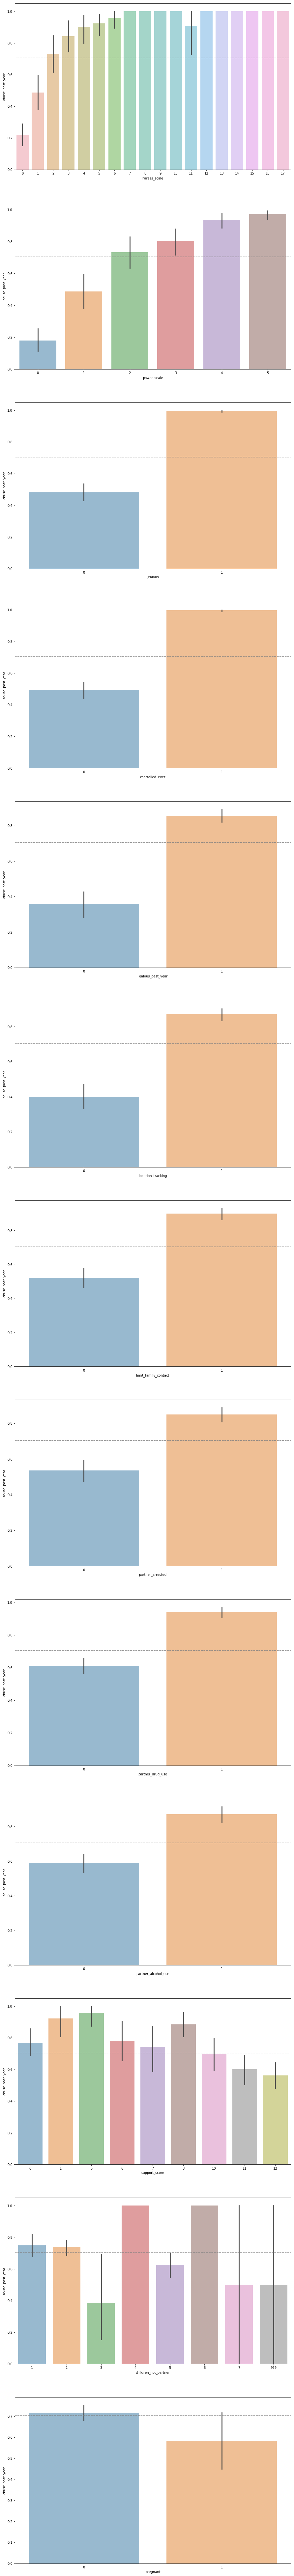

In [27]:
explore.make_bars(train_df, 'abuse_past_year', features)

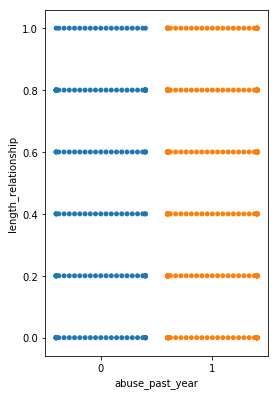

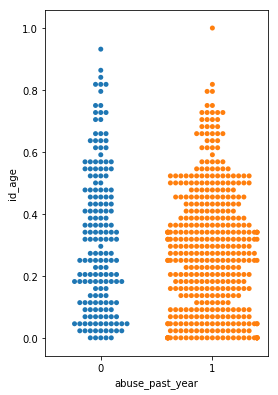

In [28]:
explore.swarrrm(train_df, 'abuse_past_year', continuous_vars)

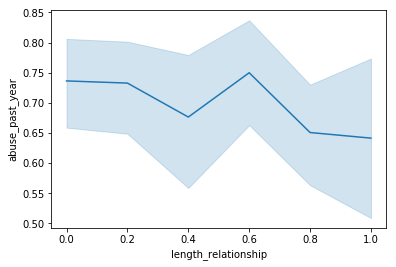

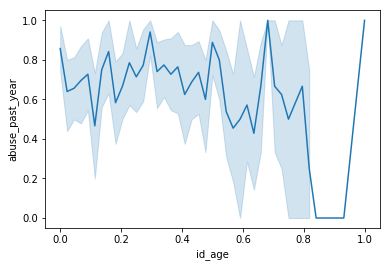

In [29]:
for feature in continuous_vars:
    sns.lineplot(x=feature, y='abuse_past_year', data=train_df)
    plt.show()

In [32]:
# histograms
# normalization(?)
# explore.plot_hist(train_df)

In [ ]:
explore.make_rel(train_df, 'id_age', 'age_disparity', hue='abuse_past_year')

# t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [ ]:
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123
time_start = time.time()

fashion_tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=250, method='exact')
tsne_results = fashion_tsne.fit_transform(X_train)

print(('t-SNE done! Time elapsed: {} seconds').format(time.time()-time_start))

In [ ]:
# Label to color dict (manual)
label_color_dict = {1:'Abuse',0:'Not Abuse'}

# Color vector creation
cvec = [label_color_dict[label] for label in y_train.abuse_past_year]

# PLot t-sne

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=cvec,
    data=X_train,
    legend="full",
    alpha=0.4
)

# Modeling:

### We will attempt several different tactics and models as a means to find the best fit for our data set.  We will try with various features and par down with what we found as being statistically significant through chi-squared testing.

# Naive Bayes

In [ ]:
# create the model
gnb = GaussianNB()
# fit the model
gnb.fit(X_train[keep], y_train)
# make predictions with the model
y_pred = gnb.predict(X_train[keep])
# predict probability with the model
y_pred_proba = gnb.predict_proba(X_train[keep])

In [ ]:
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train[keep], y_train)))

In [ ]:
# print raw confusion matrix:
# ~~~~~ edit this to display cleaner ~~~~~
print(confusion_matrix(y_train, y_pred))

In [ ]:
# classification report
print(classification_report(y_train, y_pred))


# This Gaussian Naive Bayes Model performed at 84% accuracy with the following features:

In [ ]:
keep

## Try another GNB model with a lot fewer features. These are the top 5 features of significance according to the chi squared testing.

In [ ]:
features[0:5]

In [ ]:
top5 = features[0:5]
top5_non_agg = ['jealous',
                'controlled_ever', 
                'location_tracking',
                'limit_family_contact', 
                'partner_arrested']

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train[top5_non_agg], y_train)

y_pred = gnb.predict(X_train[top5_non_agg])

y_pred_proba = gnb.predict_proba(X_train[top5_non_agg])

In [ ]:
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train[features], y_train)))

print(confusion_matrix(y_train, y_pred))


print(classification_report(y_train, y_pred))

# The GNB model performs better with the top 5 features. It has accuracy of 93%.

## Logistic Regression w/ Cross Validation: 

In [ ]:
clf = LogisticRegressionCV(cv=5,
                           random_state=0,
                          ).fit(X_train[features], y_train)

y_pred = clf.predict(X_train[features])

y_pred_proba = clf.predict_proba(X_train[features])

In [ ]:
clf.score(X_train[features], y_train) 

In [ ]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(clf.score(X_train[features], y_train)))

In [ ]:
print(confusion_matrix(y_train, y_pred))

In [ ]:
print(classification_report(y_train, y_pred))

## Decision Tree:

In [ ]:
params = {'max_depth': [2, 3, 4],
          'max_features': [None, 1, 3]}

In [ ]:
# for classificaiton you can change the algorithm as gini or entropy (information gain).  Default is gini.
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=3, random_state=0)

In [ ]:
grid = GridSearchCV(dtc, params, cv=3, iid=True)

In [ ]:
grid.fit(X_train[features], y_train)

In [ ]:
results = grid.cv_results_
results.keys()

In [ ]:
test_scores = results['mean_test_score']
test_scores

In [ ]:
params = results['params']
params

In [ ]:
for p, s in zip(params, test_scores):
    p['score'] = s

pd.DataFrame(params).sort_values(by='score')

In [ ]:
dtc.fit(X_train[features], y_train)

In [ ]:
cross_val_score(dtc, X_train[features], y_train, cv=5)

In [ ]:
y_pred = dtc.predict(X_train[features])
y_pred[0:5]

In [ ]:
y_pred_proba = dtc.predict_proba(X_train[features])
y_pred_proba

In [ ]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(dtc.score(X_train[features], y_train)))

In [ ]:
confusion_matrix(y_train, y_pred)

In [ ]:
sorted(y_train.abuse_past_year.unique())

In [ ]:
y_train.abuse_past_year.value_counts()

In [ ]:
labels = sorted(y_train.abuse_past_year.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

In [ ]:
print(classification_report(y_train, y_pred))

In [99]:
params = {'max_depth': [2, 3, 4],
          'max_features': [None, 1, 3]}

In [100]:
# for classificaiton you can change the algorithm as gini or entropy (information gain).  Default is gini.
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=3, random_state=0)

In [101]:
grid = GridSearchCV(dtc, params, cv=3, iid=True)

In [102]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4], 'max_features': [None, 1, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [103]:
results = grid.cv_results_
results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [104]:
test_scores = results['mean_test_score']
test_scores

array([0.89315526, 0.80467446, 0.89482471, 0.92153589, 0.81469115,
       0.92153589, 0.93155259, 0.87479132, 0.93155259])

In [105]:
params = results['params']
params

[{'max_depth': 2, 'max_features': None},
 {'max_depth': 2, 'max_features': 1},
 {'max_depth': 2, 'max_features': 3},
 {'max_depth': 3, 'max_features': None},
 {'max_depth': 3, 'max_features': 1},
 {'max_depth': 3, 'max_features': 3},
 {'max_depth': 4, 'max_features': None},
 {'max_depth': 4, 'max_features': 1},
 {'max_depth': 4, 'max_features': 3}]

In [106]:
for p, s in zip(params, test_scores):
    p['score'] = s

pd.DataFrame(params).sort_values(by='score')

,max_depth,max_features,score
1,2,1.0,0.804674
4,3,1.0,0.814691
7,4,1.0,0.874791
0,2,NaN,0.893155
2,2,3.0,0.894825
3,3,NaN,0.921536
5,3,3.0,0.921536
6,4,NaN,0.931553
8,4,3.0,0.931553


In [107]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [108]:
cross_val_score(dtc, X_train, y_train, cv=5)

array([0.95041322, 0.9338843 , 0.96638655, 0.87394958, 0.93277311])

In [109]:
y_pred = dtc.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 1, 0])

In [110]:
y_pred_proba = dtc.predict_proba(X_train)
y_pred_proba

array([[0.82075472, 0.17924528],
       [0.82075472, 0.17924528],
       [0.82075472, 0.17924528],
       ...,
       [0.        , 1.        ],
       [0.02777778, 0.97222222],
       [0.        , 1.        ]])

In [111]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(dtc.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.93


In [112]:
confusion_matrix(y_train, y_pred)

array([[174,   3],
       [ 38, 384]])

In [113]:
sorted(y_train.abuse_past_year.unique())

[0, 1]

In [114]:
y_train.abuse_past_year.value_counts()

1    422
0    177
Name: abuse_past_year, dtype: int64

In [115]:
labels = sorted(y_train.abuse_past_year.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,174,3
1,38,384


In [116]:
print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

          0       0.82      0.98      0.89       177
          1       0.99      0.91      0.95       422

avg / total       0.94      0.93      0.93       599



In [117]:
import graphviz
from io import StringIO
from IPython.display import Image 
import pydotplus
from sklearn import preprocessing
from sklearn import tree

In [118]:
# conda install pydotplus
def plot_decision_tree(clf,feature_name,target_name):
    '''This function creates a visualization of a decision tree in png format. 
    Takes a decision tree object, feature names of the training set and a target variable for the target name.'''
    dot_data = StringIO()  
    tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=feature_name,  
                         class_names=target_name,  
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

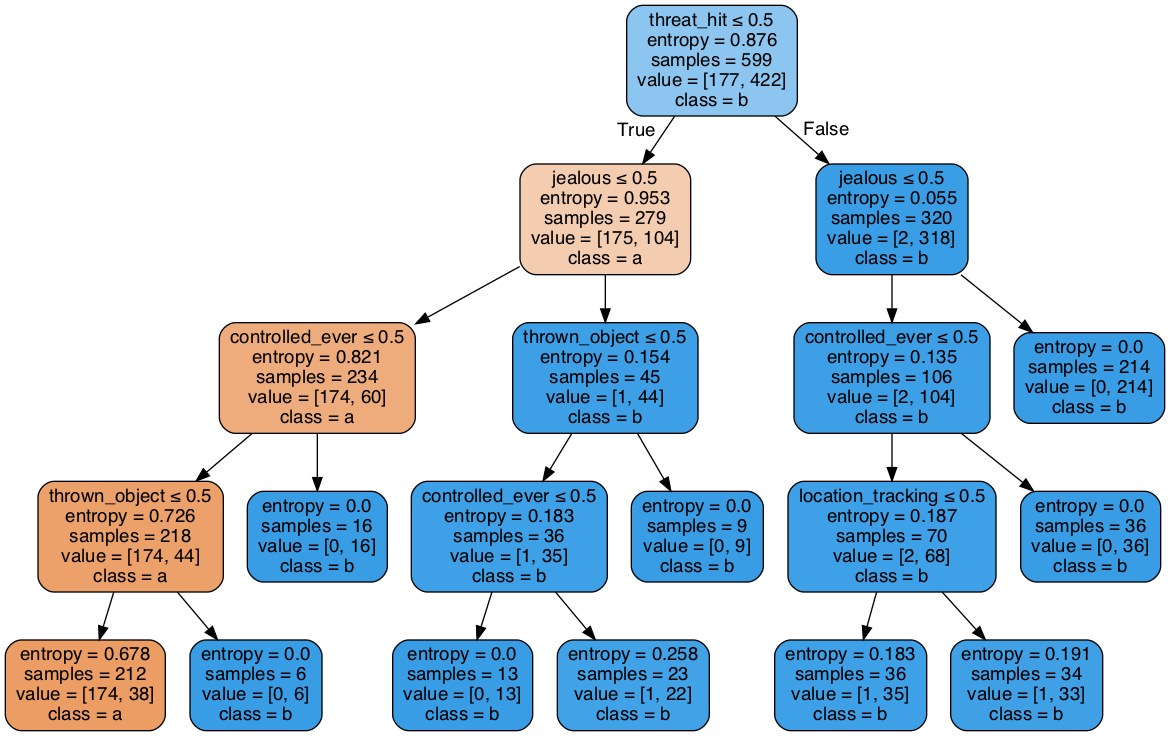

In [119]:
plot_decision_tree(dtc, X_train.columns, df.columns[1])

##  Random Forest:

In [ ]:
r_params = {'max_depth': [2, 3, 4]}

In [ ]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='entropy',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=0)

In [ ]:
r_grid = GridSearchCV(rf, r_params, cv=3, iid=True)

In [ ]:
r_grid.fit(X_train, y_train)

In [ ]:
r_results = r_grid.cv_results_
r_results.keys()

In [ ]:
r_test_scores = r_results['mean_test_score']
r_test_scores

In [ ]:
r_params = r_results['params']
r_params

In [ ]:
for p, s in zip(r_params, r_test_scores):
    p['score'] = s

pd.DataFrame(r_params).sort_values(by='score')

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
cross_val_score(rf, X_train, y_train, cv=5)

In [ ]:
print(rf.feature_importances_)

In [ ]:
y_pred = rf.predict(X_train)
y_pred

In [ ]:
y_pred_proba = rf.predict_proba(X_train)
y_pred_proba

In [ ]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

In [ ]:
print(confusion_matrix(y_train, y_pred))

In [ ]:
print(classification_report(y_train, y_pred))

# ------------ DFB WORK START HERE ------------ # 

## _So now we can see the cases where reassault happened. There are 350 cases out of 705. There were 497 cases of domestic violence._

In [ ]:
# make new dataframe out of subset of dfa where we only look at the victims of abuse
dfa_abused = dfa[dfa.abuse_past_year == 1]

In [ ]:
df6 = acquire.read_data('data06.csv')
# df8 = acquire.read_data('data08.csv') # NO USEFUL COLUMNS
df11 = acquire.read_data('data11.csv')
# df12 = acquire.read_data('data12.csv') # NO USEFUL COLUMNS

In [ ]:
six_cols = ['CASEID',
            'M11HIGH',
            'M35SAFE',
            'M41ILLGL',
            'M42DAGRR',
            'M13TALKR',
            'M32OTHER',
            'M30ARRES',
            'M31HOW',
            'M38ORDER',
           ]

eleven_cols = ['CASEID',
               'SEVERER',
               'TOTINCR',
               'THREATR',
               'SLAPR',
               'PUNCHR',
               'BEATR',
               'UWEAPON',
               'FORCEDR',
               'MISCARR',
               'RESTRAIN',
               'CHOKED',
               'NDRUNK',
               'RDRUNK',
               'BOTHDRUN',
               'NDRUGS',
               'RDRUGS',
               'BOTHDRUG',
              ]

In [ ]:
# drop dataframes down to desired features
df6 = df6[six_cols]
df11 = df11[eleven_cols]

In [ ]:
dfb = df6.merge(right=df11, on='CASEID')

In [ ]:
dfb.info()

In [ ]:
dfb = prepare.rename_columns_recid(dfb)

In [ ]:
prepare.replace_nonvals_recid(dfb)

In [ ]:
df = dfa_abused.merge(right=dfb, on='id')

In [ ]:
# formally check that there are no nulls in dataframe
prepare.get_nulls_by_column(df)

In [ ]:
# check no 2
if not prepare.get_nulls_by_row(df):
    print('no nulls!')
else:
    prepare.get_nulls_by_row(df)

In [ ]:
df.info()

In [ ]:
df_so_very_large.head()

In [ ]:
feats = [col for col in df_so_very_large]

In [ ]:
feats

In [ ]:
feats.remove('id')
feats.remove('length_relationship')
feats.remove('power_scale')
feats.remove('harass_scale')
feats.remove('id_age')
feats.remove('reassault')

In [ ]:
# split train and test
train_df, test_df = train_test_split(df_so_very_large, test_size=.15, random_state=0, stratify=df_so_very_large[['reassault']])

In [ ]:
feats

In [ ]:
sig_feats, sig_dict = explore.get_chi_squared(train_df, feats, 'reassault')

In [ ]:
sig_dict

In [ ]:
feats = [item[0] for item in explore.sort_sigs(sig_dict)]

In [ ]:
len(feats)

In [ ]:
feats